In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 75997409


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

eval_lines: 
train_lines: PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."
PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"
PlayerReply c "Can't say I have." PlayerReply c "A few times." PlayerReply c "Once or twice." DragonReply Ry "I see." DragonReply Ry "Well, what do you think of it?"
PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."
PlayerReply c "It's pretty romantic." DragonReply Ry shy "You think so?"


In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 2,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_layer_rate": 1e-4,
    "seed": seed,
    "num_epoch": 20,
    "to_freeze_count": 20
}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
***** Running training *****
  Num examples = 4332
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2720


[0] set freeze_part_layers: False


Step,Training Loss
250,2.135600
500,1.558800
750,1.286800
1000,1.081800
1250,0.902200
1500,0.751400
1750,0.607700
2000,0.489700
2250,0.406100
2500,0.339500


[46] set freeze_part_layers: True


Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2500
Confi

[2600] set freeze_part_layers: False




Training completed. Do not forget to share your model on huggingface.co/models =)




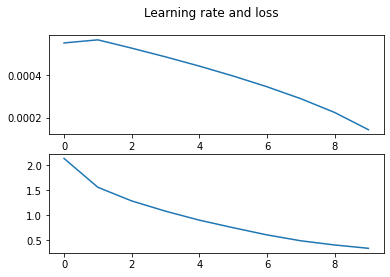

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
def generate_dragon_reply(past, prompt, top_k=None, top_p=None):
    model = train_results['model']
    tokenizer = train_results['tokenizer']
    model.eval()
    prompt = f'{past} PlayerReply c "{prompt}" DragonReply'
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
        generated, 
        do_sample=(top_k is not None and top_p is not None),
        top_p=top_p,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        max_length=128,
        num_return_sequences=1
    )
    return tokenizer.decode(sample_outputs[0], skip_special_tokens=False)[len(prompt):].strip()

prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "That\'s awesome. He\'s a cute fellow."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

# Set a fixed seed to make sure we get the same response every time.
torch.manual_seed(80085)
for (past, prompt) in prompts:
    reply = generate_dragon_reply(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "Hey! Good to see you. So, now that's the first question."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Lo think "He's doing a great job."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: Ry "Hey, I was just gone for a minute."<|endoftext|>


Prompt: What will we do here?
Reply: m "I resumed talking to Sebastian, but then he turned around to face me."<|endoftext|>




# Sampling test

Which combination is the best?

In [8]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = generate_dragon_reply(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 34, top_p: 0.45] -> Prompt: How are you?
Reply: Ry "Hey! Good to see you. So, next time we meet again, let's do it together."<|endoftext|>

[Test 1 top_k: 34, top_p: 0.45] -> Prompt: What do you think of Lorem?
Reply: Lo think "He was a very special guy."<|endoftext|>

[Test 1 top_k: 34, top_p: 0.45] -> Prompt: Oh my god, Adine. What is this?
Reply: m "Eventually, I took a deep breath and looked at me in the mirror. I was alive!"<|endoftext|>

[Test 1 top_k: 34, top_p: 0.45] -> Prompt: What will we do here?
Reply: m "I resumed talking to Sebastian, but then he turned around to ask me a few questions."<|endoftext|>

-------------
[Test 2 top_k: 44, top_p: 0.82] -> Prompt: How are you?
Reply: Ad think b "Hey [player_name]. Look at me."<|endoftext|>

[Test 2 top_k: 44, top_p: 0.82] -> Prompt: What do you think of Lorem?
Reply: Lo sad "I have no idea. He might be the one who posted this <A IGast to hang out with me... Sign me up!"<|endoftext|>

[Test 2 top_k: 44, top_p: 0.82

In [ ]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?
